# Chapter 07: Aggregations


- Aggregating is the act of collecting something together by specifying a key or _grouping_ and an _aggregation function_ that specifies how we transform one or more columns. This function must produce one result for each group, give multiple input values.

- Each grouping returns a **RelationGroupedDataset** on which specify our aggregations.

  > Notes: An important thing to consider is how exact we need an answer to be. When performing calculations over big data, it can be quite expensive to get **exact answer**, and it's often much cheaper to simply request an approximate to a resonable degree of accuracy.


## Import libraries


In [68]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col, lit

In [69]:
sparkSession = SparkSession.builder \
    .appName("Chapter 07 Learning") \
    .getOrCreate()

sparkSession.sparkContext.setLogLevel("ERROR")
sparkSession.sparkContext

<SparkContext master=local[*] appName=Chapter 07 Learning>

## Read CSV as Dataframe


In [70]:
df = sparkSession.read.format("csv").option("header", True).option("inferSchema", True).load("./data/retails.csv").coalesce(5)
df.cache()
df.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536373|    22960|JAM MAKING SET WI...|       4|2010-12-01 09:12:00|     4.25|     14911|   Netherlands|
|   536373|    22961|JAM JAR WITH PINK...|      12|2010-12-01 09:12:00|     1.95|     14911|   Netherlands|
|   536374|    21754|HOME BUILDING BLO...|       3|2010-12-01 09:20:00|     5.95|     13047|United Kingdom|
|   536375|    22423|REGENCY CAKESTAND...|       1|2010-12-01 09:24:00|    12.75|     17850|United Kingdom|
|   536375|    22301| IVORY KNITTED SCARF|       2|2010-12-01 09:24:00|      7.5|     17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows


## Aggregation Functions


In [71]:
from pyspark.sql.functions import count, countDistinct, approx_count_distinct, first, last, min, max, sum, sum_distinct, avg, expr, var_pop, stddev_pop, var_samp, stddev_samp, skewness, kurtosis, corr, covar_pop, covar_samp, collect_list, collect_set, count

**Notes**
There are some gaps between the available SQL functions and the functions that we can import in Scala and Python. This changes every release.


## count


In [72]:
df.select(count(col("StockCode"))).show()

+----------------+
|count(StockCode)|
+----------------+
|              35|
+----------------+



> **Notes:**
> When performing a `count(*)` Spark will count null values (including rows containing all nulls). However, when counting an individual column, Spark will not count the null values.


### countDistinct


Sometimes, the total number is not relevant, rather it's the number of unique groups that we want.


In [73]:
df.select(countDistinct(col("StockCode"))).show()

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                       35|
+-------------------------+



### approx_count_distinct


There are times when an approximation to a certain degree of accuracy will work just fine, and for that we can use the `approx_count_distinct` function


In [74]:
df.select(approx_count_distinct(col("StockCode"), 0.1)).show()

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                              38|
+--------------------------------+



### first and last


In [75]:
df.select(first(col="StockCode"), last(col("StockCode"))).show()

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|           22960|          22196|
+----------------+---------------+



### min and max


In [76]:
df.select(min(col="Quantity"), max(col="Quantity")).show()

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|            1|           24|
+-------------+-------------+



### sum, sumDistinct


In [77]:
df.select(sum(col="Quantity"), sum_distinct(col="Quantity")).show()

+-------------+----------------------+
|sum(Quantity)|sum(DISTINCT Quantity)|
+-------------+----------------------+
|          235|                    65|
+-------------+----------------------+



### avg


In [78]:
df.select(
    count(col("Quantity")).alias("total_transactions"),
    sum(col("Quantity")).alias("total_purchases"),
    avg(col("Quantity")).alias("avg_purchases"),
    expr("mean(Quantity)").alias("mean_purchases")
).selectExpr(
    "total_purchases/total_transactions",
    "avg_purchases",
    "mean_purchases").show()

+--------------------------------------+-----------------+-----------------+
|(total_purchases / total_transactions)|    avg_purchases|   mean_purchases|
+--------------------------------------+-----------------+-----------------+
|                     6.714285714285714|6.714285714285714|6.714285714285714|
+--------------------------------------+-----------------+-----------------+



### Variance and Standard Deviation


These are both measures of the spread of the data around the mean. However, something to note is that Spark has both for the formular for **sample** standard deviation as well as the formula for the **population** standard deviation. These are fundamentally different statistical formulae, and we need to differentiate between them. By default, Spark performs the formula for the sample standard deviation or variance if you use the variance or stddev functions


In [79]:
df.select(var_pop("Quantity"), var_samp("Quantity"), stddev_pop("Quantity"), stddev_samp("Quantity")).show()

+-----------------+------------------+--------------------+---------------------+
|var_pop(Quantity)|var_samp(Quantity)|stddev_pop(Quantity)|stddev_samp(Quantity)|
+-----------------+------------------+--------------------+---------------------+
|37.00408163265308| 38.09243697478993|   6.083098029183246|    6.171907077621141|
+-----------------+------------------+--------------------+---------------------+



### skewness and kurtosis


⭐ Skewness (asymmetry)

Skewness measures how asymmetric the data is around the mean.

- Skewness = 0 → the data is perfectly symmetric (like a normal distribution).

- Positive skew ( > 0 ) → the right tail is longer; there are more large extreme values.

- Negative skew ( < 0 ) → the left tail is longer; there are more small extreme values.

Intuition:
Skewness tells you which side has more extreme values.

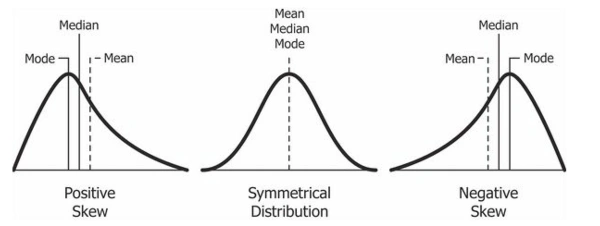


⭐ Kurtosis (tailedness)

Kurtosis measures how heavy or light the tails of the distribution are.

- High kurtosis (> 3 in Pearson’s definition)
  → heavy tails, many extreme values, more outliers.

- Low kurtosis (< 3)
  → light tails, fewer outliers.

Intuition:
Kurtosis tells you how often extreme values appear.

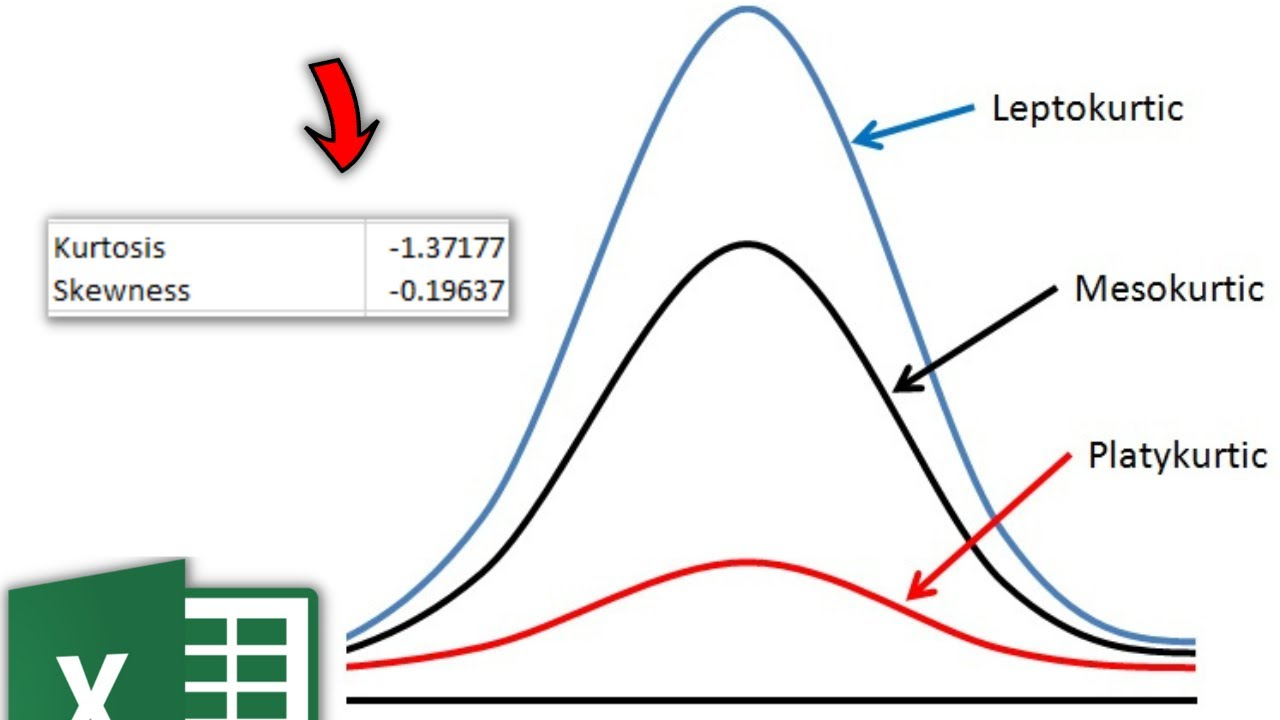


In [80]:
df.select(skewness("Quantity"), kurtosis("Quantity")).show()

+------------------+------------------+
|skewness(Quantity)|kurtosis(Quantity)|
+------------------+------------------+
| 1.883730994271023| 2.774630794133696|
+------------------+------------------+



### Covariance and Correlation


In [81]:
df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),covar_pop("InvoiceNo", "Quantity")).show()

+-------------------------+-------------------------------+------------------------------+
|corr(InvoiceNo, Quantity)|covar_samp(InvoiceNo, Quantity)|covar_pop(InvoiceNo, Quantity)|
+-------------------------+-------------------------------+------------------------------+
|     -0.12704992388848615|            -6.7647058824398325|             -6.57142857151298|
+-------------------------+-------------------------------+------------------------------+



### Aggregating to Complex Types


In [82]:
df.agg(collect_set("Country"), collect_list("Country")).show(truncate=False)

+--------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|collect_set(Country)                        |collect_list(Country)                                                                                                                                                                                                                                                                                                                                                                                                                                              |
+-

### Grouping


- A more common task is to perform calculations based on groups in the data. This is typically done on categorical data where we group our data by one column and perform aggregations on the other columns within each group.

- The best way to explain this is to begin performing some groupings. The first will be a `count`, just as we did before. We will group by each unique invoice number and get the count of items on that invoice. Note that this returns another DataFrame and is **lazily performed**.


In [83]:
df.groupBy("InvoiceNo", "CustomerID").count().show()

+---------+----------+-----+
|InvoiceNo|CustomerID|count|
+---------+----------+-----+
|   536386|     14075|    1|
|   536392|     14911|    1|
|   536380|     13047|    2|
|   536387|     13047|    1|
|   536393|     12583|    1|
|   536397|     17850|    1|
|   536385|     12583|    1|
|   536379|     12583|    2|
|   536378|     14075|    1|
|   536374|     13047|    1|
|   536399|     14911|    1|
|   536373|     14911|    2|
|   536381|     17850|    1|
|   536398|     17850|    1|
|   536382|     17850|    1|
|   536395|     13047|    1|
|   536375|     17850|    2|
|   536394|     12583|    1|
|   536377|     14075|    1|
|   536401|     17850|    1|
+---------+----------+-----+
only showing top 20 rows


### Grouping with Expressions


As we saw earlier, counting is a bit of a special case because it exists as a method. For this, usually we prefer to use the `count` function. Rather than passing that function as an expression into a `select` statement, we specify it within `agg`. This makes it possible for you to pass in arbitrary expressions that just need to have some aggregation specified. You can even do things like alias a column after transforming it for later use in your data flow:


In [84]:
df.groupBy("InvoiceNo").agg(count("Quantity").alias("quan"), expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536384|   1|              1|
|   536385|   1|              1|
|   536375|   2|              2|
|   536392|   1|              1|
|   536393|   1|              1|
|   536387|   1|              1|
|   536394|   1|              1|
|   536390|   1|              1|
|   536373|   2|              2|
|   536389|   1|              1|
|   536400|   1|              1|
|   536383|   2|              2|
|   536401|   1|              1|
|   536379|   2|              2|
|   536395|   1|              1|
|   536388|   1|              1|
|   536380|   2|              2|
|   536378|   1|              1|
|   536374|   1|              1|
|   536386|   1|              1|
+---------+----+---------------+
only showing top 20 rows


### Window Functions

In [98]:
from pyspark.sql.functions import to_date, max, dense_rank, rank, grouping_id
from pyspark.sql.window import Window

- Window functions perform aggregations on a specific "window" of rows, where each row can belong to multiple windows (unlike group-by where each row belongs to only one group). Common use cases include rolling averages, where each row might be included in multiple overlapping frames.
- Spark supports three kinds of window functions: ranking functions, analytic functions, and aggregate functions.

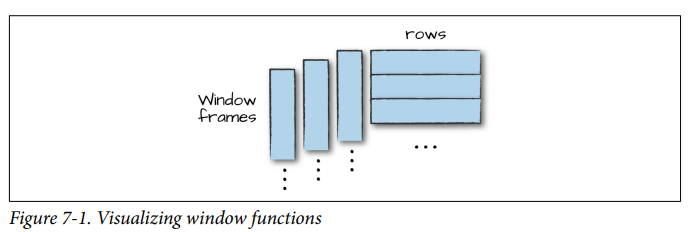


In [86]:
df_with_date = df.withColumn("date", to_date(col="InvoiceDate", format="MM/dd/yyyy H:mm"))

In [ ]:
windowSpec = Window \
    .partitionBy("CustomerID", "date") \
    .orderBy(col("Quantity").desc()) \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

In [88]:
maxPurchaseQuantity = max("Quantity").over(windowSpec)

`RANK()` vs `DENSE_RANK()`

- `RANK()`: Assigns the same rank to tied values, but the next rank is skipped.
  Example: 1, 2, 2, 4

- `DENSE_RANK()`: Assigns the same rank to tied values, but the next rank is continuous.
  Example: 1, 2, 2, 3


In [89]:
purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

In [90]:
# add the window-derived columns to the dataframe first, then query them
df_with_date_ranked = df_with_date \
    .withColumn("purchaseRank", purchaseRank) \
    .withColumn("purchaseDenseRank", purchaseDenseRank) \
    .withColumn("maxPurchaseQuantity", maxPurchaseQuantity)

df_with_date_ranked.filter(col("CustomerID").isNotNull()) \
    .orderBy("CustomerID") \
    .selectExpr(
        "CustomerID",
        "date",
        "Quantity",
        "purchaseRank as quantityRank",
        "purchaseDenseRank as quantityDenseRank",
        "maxPurchaseQuantity as maxQuantitySoFar"
    ).show()

+----------+----------+--------+------------+-----------------+----------------+
|CustomerID|      date|Quantity|quantityRank|quantityDenseRank|maxQuantitySoFar|
+----------+----------+--------+------------+-----------------+----------------+
|     12583|2010-12-01|      24|           1|                1|              24|
|     12583|2010-12-01|      24|           1|                1|              24|
|     12583|2010-12-01|      24|           1|                1|              24|
|     12583|2010-12-01|       5|           4|                2|              24|
|     12583|2010-12-01|       5|           4|                2|              24|
|     13047|2010-12-01|       6|           1|                1|               6|
|     13047|2010-12-01|       3|           2|                2|               6|
|     13047|2010-12-01|       3|           2|                2|               6|
|     13047|2010-12-01|       3|           2|                2|               6|
|     13047|2010-12-01|     

### Grouping Sets

- GROUPING SETS allow you to perform multiple group-by aggregations in a single query.
- Instead of running several separate GROUP BY statements and combining the results, you can define exactly which groupings you want within one query. This improves performance and keeps the SQL more compact.
- **Important Notes**
Grouping sets depend on null values for aggregation levels. If you
do not filter-out null values, you will get incorrect results. This
applies to cubes, rollups, and grouping sets.
- The GROUPING SETS operator is only available in SQL. To perform the same in DataFrames, we use the **rollup** and **cube** operators—which allow us to get the same results. Let’s go through those.

#### Rollups

                ( A, B, C )
                     |
                     v
                ( A, B )
                     |
                     v
                  ( A )
                     |
                     v
                  ( )


In [101]:
df_no_null = df_with_date.dropna(subset=["date", "Country", "Quantity"])

rolled_up_df = df_no_null.rollup("date", "Country") \
    .agg(sum("Quantity").alias("totalQuantity")) \
    .selectExpr("date", "Country", "totalQuantity") \
    .orderBy("date")

rolled_up_df.show()

+----------+--------------+-------------+
|      date|       Country|totalQuantity|
+----------+--------------+-------------+
|      NULL|          NULL|          235|
|2010-12-01|United Kingdom|           61|
|2010-12-01|        France|           82|
|2010-12-01|          NULL|          235|
|2010-12-01|         Spain|           23|
|2010-12-01|   Netherlands|           69|
+----------+--------------+-------------+



### Cube

                           ( A, B, C )
                     /        |        \
                    /         |         \
           ( A, B )     ( A, C )     ( B, C )
              |            |            |
              |            |            |
            ( A )        ( B )        ( C )
              \            |            /
               \           |           /
                          ( )


In [103]:
df_no_null.cube("date", "Country").agg(sum(col("Quantity"))).select("date", "Country", "sum(Quantity)").orderBy("Date").show()

+----------+--------------+-------------+
|      date|       Country|sum(Quantity)|
+----------+--------------+-------------+
|      NULL|        France|           82|
|      NULL|United Kingdom|           61|
|      NULL|          NULL|          235|
|      NULL|         Spain|           23|
|      NULL|   Netherlands|           69|
|2010-12-01|United Kingdom|           61|
|2010-12-01|        France|           82|
|2010-12-01|          NULL|          235|
|2010-12-01|         Spain|           23|
|2010-12-01|   Netherlands|           69|
+----------+--------------+-------------+



In [106]:
df_no_null.cube("CustomerID", "StockCode") \
	.agg(grouping_id(), sum("Quantity")) \
	.orderBy(expr("grouping_id()").desc()) \
	.show(n=100, truncate=False)

+----------+---------+-------------+-------------+
|CustomerID|StockCode|grouping_id()|sum(Quantity)|
+----------+---------+-------------+-------------+
|NULL      |NULL     |3            |235          |
|NULL      |22423    |2            |1            |
|NULL      |22617    |2            |3            |
|NULL      |23085    |2            |6            |
|NULL      |22618    |2            |4            |
|NULL      |21791    |2            |24           |
|NULL      |22619    |2            |6            |
|NULL      |22196    |2            |6            |
|NULL      |22866    |2            |5            |
|NULL      |21790    |2            |24           |
|NULL      |21733    |2            |6            |
|NULL      |22620    |2            |2            |
|NULL      |20725    |2            |6            |
|NULL      |21755    |2            |3            |
|NULL      |85032    |2            |2            |
|NULL      |21975    |2            |24           |
|NULL      |22415    |2        

### Pivot

Pivots make it possible to convert a row into a column. For example, in our current data we have a Country column. With a pivot, we can aggregate according to some function for each of those countries and display the results in an easy-to-query way

In [113]:
df_with_date.groupBy("date").pivot("Country").sum("UnitPrice").show()

+----------+------+-----------+------------------+--------------+
|      date|France|Netherlands|             Spain|United Kingdom|
+----------+------+-----------+------------------+--------------+
|2010-12-01|  8.15|       32.9|12.500000000000002|          74.9|
+----------+------+-----------+------------------+--------------+

